In [2]:
import sys, os 
sys.path.append(os.path.expanduser("~/git/butools/Python"))

In [3]:
import numpy as np
import sys
sys.path.append(r'C:\Users\Eshel\workspace\butools2\Python')
import os
import argparse
from tqdm import tqdm
from butools.ph import *
from butools.map import *
from butools.queues import *
import time
from butools.mam import *
# from butools.dph import *
from scipy.linalg import expm, sinm, cosm
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
from scipy.stats import rv_discrete
from scipy.special import factorial
import pickle as pkl

In [4]:
def compute_pdf_within_range(x_vals, s, A):
    '''
    compute_pdf_within_range
    :param x_vals:
    :param s:
    :param A:
    :return:
    '''
    pdf_list = []
    for x in x_vals:
        pdf_list.append(compute_pdf(x, s, A).flatten())

    return pdf_list

def compute_cdf_within_range(x_vals, s, A):
    '''
    compute_cdf_within_range
    :param x_vals:
    :param s:
    :param A:
    :return:
    '''
    pdf_list = []
    for x in x_vals:
        pdf_list.append(compute_cdf(x, s, A).flatten())

    return pdf_list

def compute_pdf(x, s, A):
    '''
    x: the value of pdf
    s: inital probs
    A: Generative matrix
    '''
    A0 = -np.dot(A, np.ones((A.shape[0], 1)))
    return np.dot(np.dot(s, expm(A * x)), A0)


def compute_cdf(x, s, A):
    '''
    x: the value of pdf
    s: inital probs
    A: Generative matrix
    '''
    A0 = -np.dot(A, np.ones((A.shape[0], 1)))
    return 1 - np.sum(np.dot(s, expm(A * x)))





def create_gen_erlang_given_sizes(group_sizes, rates, probs=False):
    '''
    create_gen_erlang_given_sizes
    :param group_sizes:
    :param rates:
    :param probs:
    :return:
    '''
    ph_size = np.sum(group_sizes)
    erlang_list = [generate_erlang_given_rates(rates[ind], ph_size) for ind, ph_size in enumerate(group_sizes)]
    final_a = np.zeros((ph_size, ph_size))
    final_s = np.zeros(ph_size)
    if type(probs) == bool:
        rand_probs = np.random.dirichlet(np.random.rand(group_sizes.shape[0]), 1)
        rands = np.random.rand(group_sizes.shape[0])
        rand_probs = rands / np.sum(rands).reshape((1, rand_probs.shape[0]))
    else:
        rand_probs = probs
    for ind in range(group_sizes.shape[0]):
        final_s[np.sum(group_sizes[:ind])] = rand_probs[0][ind]  # 1/diff_list.shape[0]
        final_a[np.sum(group_sizes[:ind]):np.sum(group_sizes[:ind]) + group_sizes[ind],
        np.sum(group_sizes[:ind]):np.sum(group_sizes[:ind]) + group_sizes[ind]] = erlang_list[ind]

    return final_s, final_a


def create_gen_erlang_many_ph(max_ph_size = 500):
    '''
    create_gen_erlang_many_ph
    :param max_ph_size:
    :return:
    '''
    ph_size = np.random.randint(1, max_ph_size)
    num_groups = np.random.randint(2,20)
    group_sizes = np.random.randint(1,25,num_groups)
    group_sizes_1 = (group_sizes*ph_size/np.sum(group_sizes)).astype(int)+1
    rates = ((np.ones(num_groups)*np.random.uniform(1, 1.75))**np.arange(num_groups))
    s,A = create_gen_erlang_given_sizes(group_sizes_1, rates)

    A = A*compute_first_n_moments(s, A, 1)[0][0]
    return (s,A)


def ser_moment_n(s, A, mom):
    '''
    ser_moment_n
    :param s:
    :param A:
    :param mom:
    :return:
    '''
    e = np.ones((A.shape[0], 1))
    try:
        mom_val = ((-1) ** mom) *factorial(mom)*np.dot(np.dot(s, matrix_power(A, -mom)), e)
        if mom_val > 0:
            return mom_val
        else:
            return False
    except:
        return False

def compute_first_n_moments(s, A, n=3):
    '''
    compute_first_n_moments
    :param s:
    :param A:
    :param n:
    :return:
    '''
    moment_list = []
    for moment in range(1, n + 1):
        moment_list.append(ser_moment_n(s, A, moment))
    return moment_list


def create_erlang_row(rate, ind, size):
    aa = np.zeros(size)
    aa[ind] = -rate
    if ind < size - 1:
        aa[ind + 1] = rate
    return aa


def create_row_rates(row_ind, is_absorbing, in_rate, non_abrosing_out_rates, ph_size, non_absorbing):
    '''
    row_ind: the current row
    is_abosboing: true if it an absorbing state
    in_rate: the rate on the diagonal
    non_abrosing_out_rates: the matrix with non_abrosing_out_rates
    ph_size: the size of phase type
    return: the ph row_ind^th of the ph matrix
    '''

    finarr = np.zeros(ph_size)
    finarr[row_ind] = -in_rate  ## insert the rate on the diagonal with a minus sign
    if is_absorbing:  ## no further changes is requires
        return finarr
    else:
        all_indices = np.arange(ph_size)
        all_indices = all_indices[all_indices != row_ind]  ## getting the non-diagonal indices
        rate_ind = np.where(non_absorbing == row_ind)  ## finding the current row in non_abrosing_out_rates
        finarr[all_indices] = non_abrosing_out_rates[rate_ind[0][0]]
        return finarr

def generate_erlang_given_rates(rate, ph_size):
    '''
    generate_erlang_given_rates
    :param rate:
    :param ph_size:
    :return:
    '''
    A = np.identity(ph_size)
    A_list = [create_erlang_row(rate, ind, ph_size) for ind in range(ph_size)]
    A = np.concatenate(A_list).reshape((ph_size, ph_size))
    return A

def gives_rate(states_inds, rate, ph_size):
    '''
    states_ind: the out states indices
    rate: the total rate out
    return: the out rate array from that specific state
    '''
    final_rates = np.zeros(ph_size - 1)  ## initialize the array
    rands_weights_out_rate = np.random.rand(states_inds.shape[0])  ## Creating the weights of the out rate
    ## Computing the out rates
    final_rates[states_inds] = (rands_weights_out_rate / np.sum(rands_weights_out_rate)) * rate
    return final_rates

def give_s_A_given__fixed_size(ph_size, scale_low, scale_high):
    '''
    give_s_A_given__fixed_size
    :param ph_size:
    :param scale_low:
    :param scale_high:
    :return:
    '''
    if ph_size > 1:
        potential_vals = np.linspace(scale_low, scale_high, 20000)
        randinds = np.random.randint(potential_vals.shape[0], size=ph_size)
        ser_rates = (potential_vals[randinds]).reshape((1, ph_size))
        w = np.random.rand(ph_size)
        numbers = np.arange(0, ph_size + 1)  # an array from 0 to ph_size + 1
        p0 = 0.9
        distribution = (w / np.sum(w)) * (1 - p0)  ## creating a pdf from the weights of w
        distribution = np.append(p0, distribution)
        random_variable = rv_discrete(values=(numbers, distribution))  ## constructing a python pdf
        ww = random_variable.rvs(size=1)

        ## choosing the states that are absorbing
        absorbing_states = np.sort(np.random.choice(ph_size, ww[0], replace=False))
        non_absorbing = np.setdiff1d(np.arange(ph_size), absorbing_states, assume_unique=True)

        N = ph_size - ww[0]  ## N is the number of non-absorbing states
        p = np.random.rand()  # the probability that a non absorbing state is fully transient
        mask_full_trans = np.random.choice([True, False], size=N, p=[p, 1 - p])  # True if row sum to 0
        if np.sum(mask_full_trans) == mask_full_trans.shape[0]:
            mask_full_trans = False
        ser_rates = ser_rates.flatten()

        ## Computing the total out of state rate, if absorbing, remain the same
        p_outs = np.random.rand(N)  ### this is proportional rate out
        orig_rates = ser_rates[non_absorbing]  ## saving the original rates
        new_rates = orig_rates * p_outs  ## Computing the total out rates
        out_rates = np.where(mask_full_trans, orig_rates, new_rates)  ## Only the full trans remain as the original

        ## Choosing the number of states that will have a postive rate out for every non-absorbing state

        num_trans_states = np.random.randint(1, ph_size, N)

        ## Choosing which states will go from each non-absorbing state
        trans_states_list = [np.sort(np.random.choice(ph_size - 1, num_trans_states[j], replace=False)) for j in
                             range(N)]
        # Computing out rates
        non_abrosing_out_rates = [gives_rate(trans_states, out_rates[j], ph_size) for j, trans_states in
                                  enumerate(trans_states_list)]
        ## Finalizing the matrix

        #     return trans_states_list, absorbing_states, ser_rates, non_abrosing_out_rates
        lists_rate_mat = [
            create_row_rates(row_ind, row_ind in absorbing_states, ser_rates[row_ind], non_abrosing_out_rates, ph_size,
                             non_absorbing) for row_ind in range(ph_size)]
        A = np.concatenate(lists_rate_mat).reshape((ph_size, ph_size))  ## converting all into one numpy array

        num_of_pos_initial_states = np.random.randint(1, ph_size + 1)
        non_zero_probs = np.random.dirichlet(np.random.rand(num_of_pos_initial_states), 1)
        inds_of_not_zero_probs = np.sort(np.random.choice(ph_size, num_of_pos_initial_states, replace=False))
        s = np.zeros(ph_size)
        s[inds_of_not_zero_probs] = non_zero_probs

    else:
        s = np.array([1.])
        potential_vals = np.linspace(scale_low, scale_high, 20000)
        randinds = np.random.randint(potential_vals.shape[0], size=ph_size)
        ser_rates = (potential_vals[randinds]).reshape((1, ph_size))
        A = -ser_rates

    return (s, A)

def balance_sizes(sizes):
    '''
    balance_sizes
    :param sizes:
    :return:
    '''

    for ind in range(sizes.shape[0]):
        if sizes[ind] < 3:
            ind_max = np.argmax(sizes)
            if sizes[ind_max] >2 :
                sizes[ind] +=1
                sizes[ind_max] -=1
    return sizes

def recursion_group_size(group_left, curr_vector, phases_left):
    '''
    recursion_group_size
    :param group_left:
    :param curr_vector:
    :param phases_left:
    :return:
    '''

    if group_left == 1:
        return np.append(phases_left, curr_vector)
    else:

        if phases_left + 1 - group_left == 1:
            curr_size = 1
        else:
            curr_size =  1+ np.random.binomial(phases_left + 1 - group_left-1, np.random.uniform(0.1,0.5))
        return recursion_group_size(group_left - 1, np.append(curr_size, curr_vector), phases_left - curr_size)

def create_mix_erlang_ph(ph_size, scale_low=1, max_scale_high=15, max_ph=500):
    '''
    Mixure of erlangs
    :param ph_size:
    :param scale_low:
    :param max_scale_high:
    :param max_ph:
    :return:
    '''

    if ph_size > 2:
        ph_size_gen_ph = np.random.randint(2, ph_size)

    else:
        return create_gen_erlang_many_ph(ph_size)


    scale_high = np.random.uniform(2, max_scale_high)

    num_groups = sample_num_groups(ph_size_gen_ph)
    group_sizes_gen_ph = recursion_group_size(num_groups, np.array([]), ph_size_gen_ph) #(group_sizes * ph_size_gen_ph / np.sum(group_sizes)).astype(int) + 1
    if np.random.rand() > 0.01:
        group_sizes_gen_ph = balance_sizes(group_sizes_gen_ph)
    erlang_list_gen_ph = [give_s_A_given__fixed_size(size, scale_low, scale_high) for size in group_sizes_gen_ph.astype(int)]
    erlang_list_gen_ph_A = [lis[1] for lis in erlang_list_gen_ph]
    erlang_list_gen_ph_s = [lis[0] for lis in erlang_list_gen_ph]

    ph_size_erl = ph_size - ph_size_gen_ph

    num_groups = sample_num_groups(ph_size_erl)

    if np.random.rand() > 0.8:
        rates = np.random.rand(num_groups)*200
    else:
        rates = np.random.uniform(1, 1.75) ** (np.random.rand(num_groups) * 10)
    group_sizes_erl = recursion_group_size(num_groups, np.array([]), ph_size_erl).astype(int) # (group_sizes * ph_size_erl / np.sum(group_sizes)).astype(int) + 1
    if np.random.rand() >0.01:
        group_sizes_erl = balance_sizes(group_sizes_erl)
    erlang_list_erl = [generate_erlang_given_rates(rates[ind], ph_size_erl) for ind, ph_size_erl in
                       enumerate(group_sizes_erl)]
    group_sizes = np.append(group_sizes_gen_ph, group_sizes_erl)
    group_sizes = group_sizes.astype(int)
    rand_probs = np.random.dirichlet(np.random.rand(group_sizes.shape[0]), 1)

    ph_list = erlang_list_gen_ph_A + erlang_list_erl

    ph_size = np.sum(group_sizes)
    A = np.zeros((int(ph_size), int(ph_size)))
    s = np.zeros(int(ph_size))
    for ind in range(group_sizes.shape[0]):
        if ind < group_sizes_gen_ph.shape[0]:
            s[int(np.sum(group_sizes[:ind])):int(np.sum(group_sizes[:ind]) + group_sizes[ind])] = rand_probs[0][ind] * \
                                                                                        erlang_list_gen_ph_s[ind]
        else:
            s[np.sum(group_sizes[:ind])] = rand_probs[0][ind]  # 1/diff_list.shape[0]
        A[np.sum(group_sizes[:ind]):np.sum(group_sizes[:ind]) + group_sizes[ind],
        np.sum(group_sizes[:ind]):np.sum(group_sizes[:ind]) + group_sizes[ind]] = ph_list[ind]

    fst_mom = compute_first_n_moments(s, A, 1)
    if type(fst_mom[0]) != bool:
        A = A * fst_mom[0][0]
        fst_mom = compute_first_n_moments(s, A, 1)
        return (s, A)

    else:
        return False



def create_gen_erlang_many_ph(ph_size):
    '''
    create_gen_erlang_many_ph
    :param ph_size:
    :return:
    '''

    num_groups = sample_num_groups(ph_size)

    group_sizes_1 = recursion_group_size(num_groups, np.array([]), ph_size).astype(int)
    if np.random.rand()>0.01:
        group_sizes_1 = balance_sizes(group_sizes_1)
    rates = np.random.uniform(1, 1.75)**(np.random.rand(num_groups)*10) # ((np.ones(num_groups)*np.random.uniform(1, 1.85))**np.arange(num_groups))
    s,A = create_gen_erlang_given_sizes(group_sizes_1, rates)

    A = A*compute_first_n_moments(s, A, 1)[0][0]
    return (s,A)

def sample_num_groups(n, thresh =0.98):
    '''
    sample_num_groups
    :param n:
    :param thresh:
    :return:
    '''
    if np.random.rand()>thresh:
        num = 1+np.random.binomial(n-1, np.random.uniform(0.2,0.99))
    elif np.random.rand()>0.9:
        num = 1+np.random.binomial(int(n*0.1), np.random.uniform(0.3,0.87))
    else:
        if n<10:
            portion = 0.3
        else:
            portion = 0.8
        num = 1+np.random.binomial(min(10,int(n-1)*portion), np.random.uniform(0.1,0.9))
    if (num==1) & (n>1 ) &(np.random.rand()>0.4):
        num +=1
    return num

def create_Erlang_given_ph_size(ph_size):
    '''
    create_Erlang_given_ph_size
    :param ph_size:
    :return:
    '''
    s = np.zeros(ph_size)
    s[0] = 1
    rate = ph_size
    A = generate_erlang_given_rates(rate, ph_size)
    # A = A*compute_first_n_moments(s, A, 1)[0][0]
    return (s,A)

def send_to_the_right_generator(num_ind, ph_size):

    if num_ind == 0: ## Any arbitrary ph
        s_A =  create_mix_erlang_ph(ph_size) # give_s_A_given_size(np.random.randint(60, max_ph_size))
    elif num_ind == 1:
        s_A = create_gen_erlang_many_ph(ph_size)
    else:
        s_A = create_Erlang_given_ph_size(ph_size)
    if type(s_A) != bool:
        try:

            s = s_A[0]
            A = s_A[1]

            return (s,A)

        except:
            print('Not able to extract s and A')


# def main(args):



#     if sys.platform == 'linux':

#         curr_path = os.getcwd()

#         if 'management' in curr_path:
#             args.data_path = '/home/elirans/scratch/non_renewal'
#         else:
#             args.data_path = '/scratch/eliransc/ph_random/ph_for_feed_forward'


#     for ind in range(args.num_examples):

#         a_size = np.random.randint(20, 30)
#         print(a_size)

#         elements = [0, 1, 2]
#         probabilities = [0.3, 0.4, 0.3]
#         flag = True

#         while flag:  # sample until it is valid

#             arrival_result = send_to_the_right_generator(np.random.choice(elements, 1, p=probabilities)[0], a_size)
#             if arrival_result:
#                 s_arrival, A_arrival = arrival_result
#                 flag = False


#         # x_vals = np.linspace(0,3,50)
#         # y_vals = compute_pdf_within_range(x_vals, s_arrival, A_arrival)
#         # y_list.append(y_vals)


#         arrivals = SamplesFromPH(ml.matrix(s_arrival), A_arrival, args.num_arrivals)
#         moms = compute_first_n_moments(s_arrival, A_arrival, args.num_moms)
#         data = (s_arrival, A_arrival, moms, arrivals)

#         sample_num = np.random.randint(1, 9999999)

#         pkl.dump(data, open(os.path.join(args.data_path, 'ph_size_'+str(a_size)+ '_num_'+ str(sample_num) +'.pkl'), 'wb'))




def ser_moment_n(s, A, mom):
    '''
    ser_moment_n
    :param s:
    :param A:
    :param mom:
    :return:
    '''
    e = np.ones((A.shape[0], 1))
    try:
        mom_val = ((-1) ** mom) *factorial(mom)*np.dot(np.dot(s, matrix_power(A, -mom)), e)
        if mom_val > 0:
            return mom_val
        else:
            return False
    except:
        return False

def compute_first_n_moments(s, A, n=3):
    '''
    compute_first_n_moments
    :param s:
    :param A:
    :param n:
    :return:
    '''
    moment_list = []
    for moment in range(1, n + 1):
        moment_list.append(ser_moment_n(s, A, moment))
    return moment_list


In [5]:
a_size = np.random.randint(10, 12)
elements = [0, 1, 2]
probabilities = [0.3, 0.4, 0.3]

a, A = send_to_the_right_generator(np.random.choice(elements, 1, p=probabilities)[0], a_size)


In [6]:
x_vals = np.linspace(0,5,150)
y_vals =  compute_pdf_within_range(x_vals,a, A)
y_vals = [val.item() for val in y_vals]


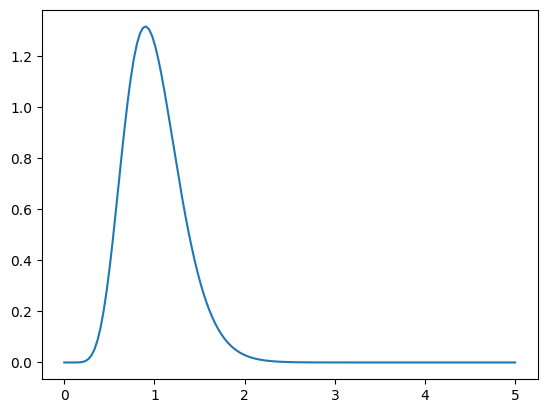

In [7]:
plt.figure()
plt.plot(x_vals, y_vals)
plt.show()

In [8]:
a_size = np.random.randint(2, 6)
elements = [0, 1, 2]
probabilities = [0.1, 0.8, 0.1]

a, A = send_to_the_right_generator(np.random.choice(elements, 1, p=probabilities)[0], a_size)
b, B = AcyclicPHFromME(ml.matrix(a), A)
A


array([[-3.,  3.,  0.],
       [ 0., -3.,  3.],
       [ 0.,  0., -3.]])

In [11]:
B

matrix([[-0.97943039,  0.97943039,  0.        ],
        [ 0.        , -0.97943039,  0.97943039],
        [ 0.        ,  0.        , -2.66683355]])

In [12]:
from scipy.special import factorial

In [9]:
a = np.array([1,0,0])

A = np.array([[-3,2,0],[0,-2,1],[0,0,-2]])

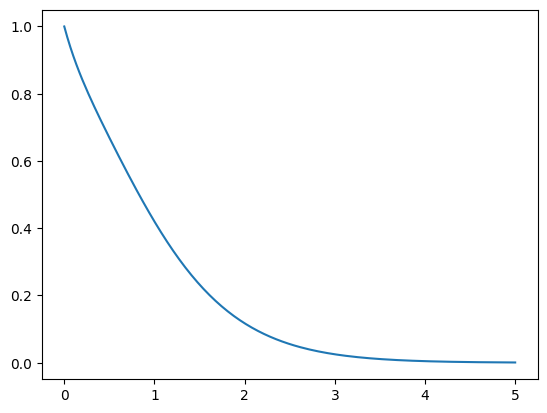

In [10]:
x_vals = np.linspace(0,5,150)
y_vals =  compute_pdf_within_range(x_vals,a, A)
y_vals = [val.item() for val in y_vals]
plt.figure()
plt.plot(x_vals, y_vals)
plt.show()

In [11]:
A = A*0.83333333

In [16]:
compute_first_n_moments(a,A, 3)

[array([1.]), array([1.76000001]), array([4.27200005])]

In [18]:
a = np.zeros(10)
a[0] = 1

In [19]:
a

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [20]:
np.random.uniform()

0.8573510663130934

In [21]:
rates = np.random.uniform(0.001, 10, 100)
probs = np.random.rand(100,9)

In [22]:
probs

array([[3.83348671e-01, 6.42163176e-01, 3.68016623e-01, 3.76309358e-01,
        5.12092124e-01, 9.90967991e-01, 4.95492529e-01, 8.05001868e-01,
        7.47281817e-01],
       [7.46536945e-01, 8.30783484e-01, 2.87289299e-01, 9.40176610e-01,
        7.93649005e-01, 3.10416397e-02, 5.48426982e-01, 4.32328424e-01,
        9.76723713e-01],
       [4.26377712e-02, 9.83829481e-01, 3.85377080e-01, 9.14350118e-01,
        8.66476787e-02, 6.36198250e-01, 7.50065347e-01, 4.24860103e-01,
        4.95775779e-01],
       [1.98847212e-01, 6.65486147e-03, 2.63819940e-01, 5.52077261e-02,
        3.97714743e-01, 1.19109325e-01, 9.53004068e-01, 7.14644344e-01,
        4.35020830e-01],
       [8.75326002e-01, 4.24005494e-01, 4.52595794e-03, 3.24556328e-01,
        3.70513357e-01, 6.14450997e-01, 6.08089949e-01, 6.05607928e-01,
        9.80346172e-01],
       [8.07295158e-01, 8.40507281e-01, 9.76577550e-01, 6.31165230e-01,
        8.73937705e-01, 2.41431383e-01, 3.65761635e-01, 1.48275829e-01,
        8.0

In [23]:
import sys
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
